In [1]:
import boto3, json, sagemaker, time
from sagemaker import get_execution_role

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
#role

In [3]:
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

In [4]:
region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

In [5]:
region

'us-east-1'

In [6]:
base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:21.08-py3".format(
    account_id=account_id_map[region], region=region, base=base
)

In [7]:
triton_image_uri

'785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:21.08-py3'

In [8]:
import numpy as np
from PIL import Image

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{sagemaker_session.boto_region_name}",
    "datasets/image/pets/shiba_inu_dog.jpg",
    "shiba_inu_dog.jpg",
)

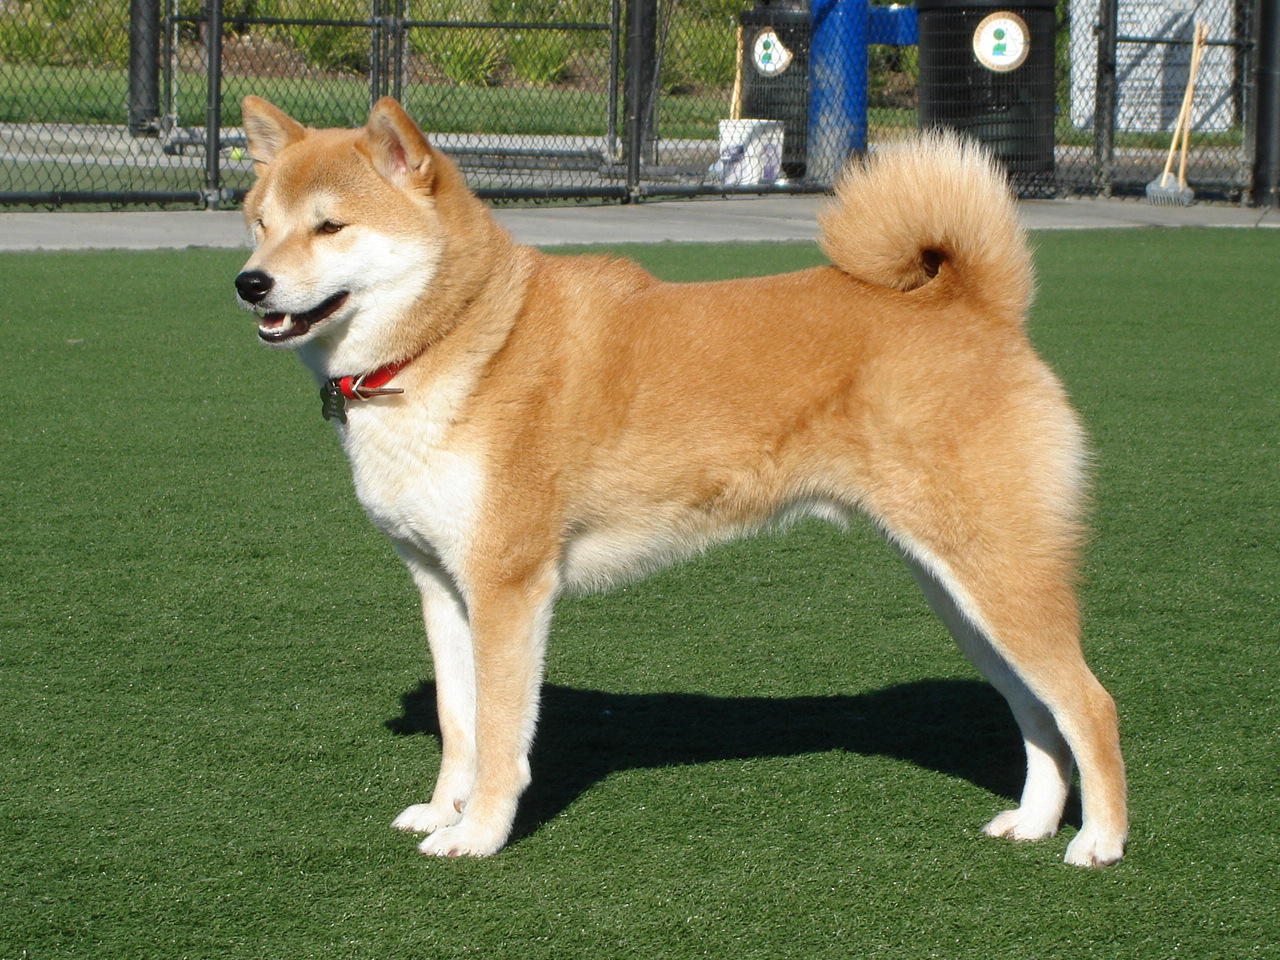

In [9]:
im = Image.open(r"shiba_inu_dog.jpg")
im.show()

In [10]:
def get_sample_image():
    image_path = "./shiba_inu_dog.jpg"
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = (np.array(img).astype(np.float32) / 255) - np.array(
        [0.485, 0.456, 0.406], dtype=np.float32
    ).reshape(1, 1, 3)
    img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    img = np.transpose(img, (2, 0, 1))
    return img.tolist()

In [11]:
!mkdir -p triton-serve-pt/resnet/1/

In [12]:
configuration = """
name: "resnet"
platform: "pytorch_libtorch"
max_batch_size: 32
input [
 {
    name: "input__0"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
  }
]
output {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 1000 ]
  }
"""

with open('triton-serve-pt/resnet/config.pbtxt', 'w') as file:
    file.write(configuration)

In [13]:
!cp -f ./model.pt triton-serve-pt/resnet/1/

In [14]:
!tar -C triton-serve-pt/ -czf model.tar.gz resnet

In [15]:
model_uri = sagemaker_session.upload_data(path="model.tar.gz", key_prefix="triton-serve-pt")

In [16]:
#model_uri

's3://sagemaker-us-east-1-392055498132/triton-serve-pt/model.tar.gz'

In [17]:
triton_image_uri

'785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:21.08-py3'

In [18]:
sm_model_name = "triton-resnet-pt-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": triton_image_uri,
    "ModelDataUrl": model_uri,
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "resnet"},
}

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:392055498132:model/triton-resnet-pt-2024-03-29-16-47-00


In [19]:
endpoint_config_name = "triton-resnet-pt-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:392055498132:endpoint-config/triton-resnet-pt-2024-03-29-16-47-23


In [20]:
endpoint_name = "triton-resnet-pt-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm_client.create_endpoint(
                                                     EndpointName=endpoint_name, 
                                                     EndpointConfigName=endpoint_config_name
                                                    )

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:392055498132:endpoint/triton-resnet-pt-2024-03-29-16-47-26


In [21]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

cnt = 0
while status == "Creating":
    cnt += 1
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print(cnt, "Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
1 Status: Creating
2 Status: Creating
3 Status: Creating
4 Status: Creating
5 Status: InService
Arn: arn:aws:sagemaker:us-east-1:392055498132:endpoint/triton-resnet-pt-2024-03-29-16-47-26
Status: InService


In [27]:
payload = {
    "inputs": [
        {
            "name": "input__0",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": get_sample_image(),
        }
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/octet-stream", Body=json.dumps(payload)
)

response_dict = json.loads(response["Body"].read().decode("utf8"))

In [28]:
## Process endpoint response directly

In [ ]:
print(response_dict)

In [23]:
resnet_predictions = response_dict['outputs'][0]['data']

In [24]:
with open('./imagenet-simple-labels.json') as file:
    labels = json.load(file)

In [26]:
print(labels[np.argmax(resnet_predictions)])

Alaskan Malamute


In [ ]:
## Use Triton Client

In [29]:
!pip install nvidia-pyindex
!pip install tritonclient[http]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [30]:
import tritonclient.http as httpclient

def _get_sample_image_binary(input_name, output_name):
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput(input_name, [1, 3, 224, 224], "FP32"))
    input_data = np.array(get_sample_image(), dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length


def get_sample_image_binary_pt():
    return _get_sample_image_binary("input__0", "output__0")


def get_sample_image_binary_trt():
    return _get_sample_image_binary("input", "output")

In [35]:
request_body, header_length = get_sample_image_binary_pt()

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
        header_length
    ),
    Body=request_body,
)

# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response["ContentType"][len(header_length_prefix) :]

# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response["Body"].read(), header_length=int(header_length_str)
)
resnet_prediction_via_triton_client = result.as_numpy("output__0")
print(resnet_prediction_via_triton_client)

[[-1.24238670e+00  2.47018531e-01 -1.71944475e+00 -2.98377419e+00
  -3.00313783e+00 -1.95564854e+00 -2.48965049e+00 -3.74837667e-01
   4.31159399e-02 -1.60371554e+00 -3.87695694e+00 -1.97425604e+00
  -3.64828253e+00 -5.38874674e+00 -1.69864345e+00 -2.91555452e+00
  -1.85707390e+00  3.68550807e-01 -6.72106445e-01 -1.74029732e+00
  -4.44818878e+00 -2.33208156e+00 -3.11241603e+00 -2.23977709e+00
  -2.12387013e+00 -3.49225831e+00 -4.81953907e+00 -2.87595153e+00
  -3.05604243e+00 -3.13367701e+00 -2.46147561e+00 -4.22211230e-01
  -2.35856390e+00 -3.57243633e+00 -7.77378082e-01 -4.29438448e+00
  -1.83301234e+00 -4.48172092e+00 -2.84007001e+00 -2.19165826e+00
  -2.01509073e-01 -3.91157937e+00 -9.05075312e-01 -2.97916031e+00
  -2.12318969e+00 -3.93249702e+00 -1.33751345e+00 -2.37469816e+00
  -5.24911880e+00 -2.66397142e+00 -1.32200909e+00 -1.02401054e+00
  -1.27982640e+00 -1.48375106e+00 -1.76050031e+00 -4.45063263e-01
  -1.98288754e-01 -2.99530888e+00 -2.81290007e+00 -1.37118065e+00
  -9.05617

In [36]:
with open('./imagenet-simple-labels.json') as file:
    labels = json.load(file)

In [38]:
print(labels[np.argmax(resnet_prediction_via_triton_client)])

Alaskan Malamute
